In [38]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 파라미터 정의
def param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0):
    beta = pump/b_freq_p
    rp = (1/4) * np.log((1 + beta) / (1 - beta))
    bs_freq = np.sqrt(1-beta**2)*b_freq_p + b_freq - b_freq_p
    a_freq_bs = a_freq - bs_freq
    noise = (2 * np.sinh(rp)**2 * b_loss)
    Js = np.cosh(rp)*J0

    return beta, rp, bs_freq, a_freq_bs, noise, Js

def param_reproduce(kappa_ext, delta, J0, b_freq_p, pump):
    kappa = 1
    a_freq = delta
    b_freq = delta
    a_loss = kappa
    b_loss = kappa
    ex1 = kappa_ext
    ex2 = kappa_ext

    param_squeeze = param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0)

    return a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze

In [39]:
def forward_system(t, y, params, AMP, is_noise):
    a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze = params
    beta, rp, bs_freq, a_freq_bs, noise, Js = param_squeeze
    ain = AMP
    ab_loss = a_loss+b_loss

    if not is_noise:
        noise = 0

    a = y[0] + 1j * y[1]
    bs = y[2] + 1j * y[3]
    a_dagger_bs = y[4] + 1j * y[5]
    a_dagger_a = y[6]
    bs_dagger_bs = y[7]

    # 시간 미분 계산
    da = -(1j * a_freq + a_loss) * a + np.sqrt(2 * ex1) * ain - 1j * Js * bs
    dbs = -(1j * bs_freq + b_loss) * bs - 1j * Js * a
    d_a_bs = (1j * a_freq_bs - ab_loss) * a_dagger_bs + np.sqrt(2 * ex1) * np.conj(ain) * bs - 1j * Js * (a_dagger_a-bs_dagger_bs)
    ab_imag = (a_dagger_bs - np.conj(a_dagger_bs))
    d_bs_bs = 1j * Js * ab_imag - 2 * b_loss * bs_dagger_bs + noise
    d_aa = -1j * Js * ab_imag + np.sqrt(2 * ex1) * (ain * np.conj(a) + np.conj(ain) * a) - 2 * a_loss * a_dagger_a

    return [
        da.real, da.imag,
        dbs.real, dbs.imag,
        d_a_bs.real, d_a_bs.imag,
        d_aa.real, d_bs_bs.real
    ]

def backward_system(t, y, params, AMP):
    a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, _ = params
    ain = AMP
    ab_loss = a_loss+b_loss

    a = y[0] + 1j * y[1]
    bs = y[2] + 1j * y[3]
    a_dagger_bs = y[4] + 1j * y[5]
    a_dagger_a = y[6]
    bs_dagger_bs = y[7]

    # 시간 미분 계산
    da = -(1j * a_freq + a_loss) * a + np.sqrt(2 * ex1) * ain - 1j * J0 * bs
    dbs = -(1j * b_freq + b_loss) * bs - 1j * J0 * a
    d_a_bs = (1j * (a_freq-b_freq) - ab_loss) * a_dagger_bs + np.sqrt(2 * ex1) * np.conj(ain) * bs - 1j * J0 * (a_dagger_a-bs_dagger_bs)
    ab_imag = (a_dagger_bs - np.conj(a_dagger_bs))
    d_bs_bs = 1j * J0 * ab_imag - 2 * b_loss * bs_dagger_bs
    d_aa = -1j * J0 * ab_imag + np.sqrt(2 * ex1) * (ain * np.conj(a) + np.conj(ain) * a).real - 2 * a_loss * a_dagger_a

    return [
        da.real, da.imag,
        dbs.real, dbs.imag,
        d_a_bs.real, d_a_bs.imag,
        d_aa.real, d_bs_bs.real
    ]




In [40]:
def solve_classic(params, AMP, is_forward, is_noise=True):
    y0 = np.zeros(8)
    t_span = (0, 10)
    t_eval = np.linspace(*t_span, 1000)
    if is_forward:
        sol = solve_ivp(forward_system, t_span, y0, args=(params, AMP, is_noise), t_eval=t_eval)
    else:
        sol = solve_ivp(backward_system, t_span, y0, args=(params, AMP), t_eval=t_eval)

    _,_,_,_,ex1,ex2,_,_ = params
    T12=1-np.sqrt(2 * ex1)*(sol.y[0][-1]*2)/AMP + 2*ex1*sol.y[6][-1]/AMP**2
    T14=2 * ex2 * sol.y[7][-1] / AMP**2

    return sol, T12, T14

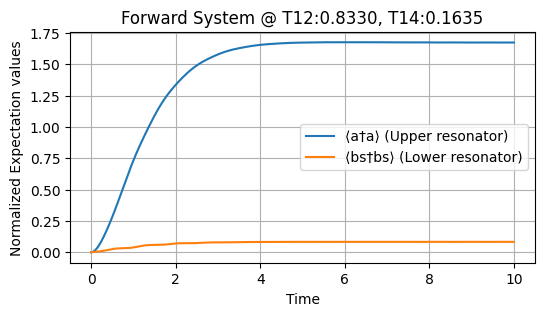

In [50]:
AMP = 10
sol, T12, T14 = solve_classic(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    AMP,
    True,
    is_noise = True
)
# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Forward System @ "+f"T12:{T12:.4f}, T14:{T14:.4f}")
plt.legend()
plt.grid(True)
plt.savefig('figs/forward_noise.png')
plt.show()


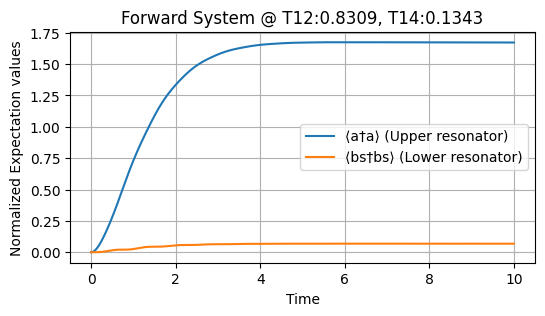

In [51]:
AMP = 10
sol, T12, T14 = solve_classic(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    AMP,
    True,
    is_noise = False
)
# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Forward System @ "+f"T12:{T12:.4f}, T14:{T14:.4f}")
plt.legend()
plt.grid(True)
plt.savefig('figs/forward_sv.png')
plt.show()


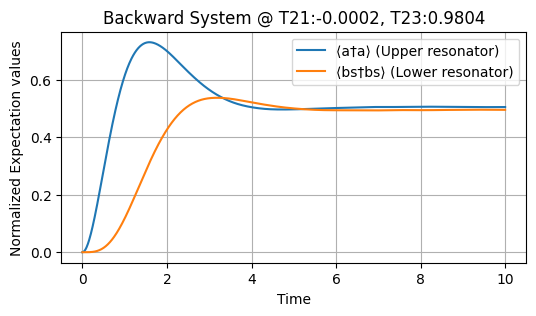

In [52]:
AMP = 10
sol, T12, T14 = solve_classic(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    AMP,
    False
)
# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Backward System @ "+f"T21:{T12:.4f}, T23:{T14:.4f}")
plt.legend()
plt.grid(True)
plt.savefig('figs/backward.png')
plt.show()
